In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap as sp
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelBinarizer

from scipy import stats

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, auc
from sklearn.metrics import f1_score, make_scorer
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 30

# I/ Exploration

In [3]:
df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [4]:
#Check du type, de la proportion de N/A et du nombre de valeurs uniques pour chaque colonne

print(f"Dataset Shape: {df.shape}") 
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary = summary.reset_index()
summary['Missing'] = df.isnull().sum().values
summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
summary['Uniques'] = df.nunique().values
 
print('**Variable Description of  data:**')
summary

Dataset Shape: (70692, 22)
**Variable Description of  data:**


,index,dtypes,Missing,PercMissing,Uniques
0,Diabetes_binary,float64,0,0.0,2
1,HighBP,float64,0,0.0,2
2,HighChol,float64,0,0.0,2
3,CholCheck,float64,0,0.0,2
4,BMI,float64,0,0.0,80
5,Smoker,float64,0,0.0,2
6,Stroke,float64,0,0.0,2
7,HeartDiseaseorAttack,float64,0,0.0,2
8,PhysActivity,float64,0,0.0,2
9,Fruits,float64,0,0.0,2


In [5]:
#Colonne Target
target_column = "Diabetes_binary"

#Colonnes Numériques
numerical_columns = [
    'BMI', 'GenHlth', 'MentHlth', 'PhysHlth','Age', 'Education', 'Income'
]

#Colonnes Catégorielles
categorical_columns = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 
    'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]


#On force le type pour chaque type de colonnes
for l in numerical_columns: df[l] = df[l].astype('float')
for l in categorical_columns: df[l] = df[l].astype('string').fillna("None").astype('category')
df[target_column] = df[target_column].astype('int')

#On ordonne notre df
df = df[ [target_column] + numerical_columns + categorical_columns ]

#On supprime les lignes ou la target est n/a
df = df.dropna(subset=target_column)

In [6]:
df.describe()

,Diabetes_binary,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,29.856985,2.837082,3.752037,5.810417,8.584055,4.920953,5.698311
std,0.500004,7.113954,1.113565,8.155627,10.062261,2.852153,1.029081,2.175196
min,0.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,25.000000,2.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,29.000000,3.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,33.000000,4.000000,2.000000,6.000000,11.000000,6.000000,8.000000
max,1.000000,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


# II/ Check Variables

## a) Colinearity

In [7]:
corr=df[numerical_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
BMI,1.000000,0.267888,0.104682,0.161862,-0.038648,-0.100233,-0.124878
GenHlth,0.267888,1.000000,0.315077,0.552757,0.155624,-0.285420,-0.382969
MentHlth,0.104682,0.315077,1.000000,0.380272,-0.101746,-0.107005,-0.219070
PhysHlth,0.161862,0.552757,0.380272,1.000000,0.084852,-0.159317,-0.279326
Age,-0.038648,0.155624,-0.101746,0.084852,1.000000,-0.107127,-0.130140
Education,-0.100233,-0.285420,-0.107005,-0.159317,-0.107127,1.000000,0.460565
Income,-0.124878,-0.382969,-0.219070,-0.279326,-0.130140,0.460565,1.000000


In [8]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        
cramers_v_matrix.astype(float).style.background_gradient(cmap='coolwarm')

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex
HighBP,0.999971,0.316486,0.103191,0.087410,0.129001,0.210710,0.136071,0.040823,0.066589,0.026959,0.035696,0.026468,0.234751,0.040791
HighChol,0.316486,0.999972,0.085890,0.093370,0.099728,0.181147,0.090422,0.047355,0.042802,0.025373,0.031463,0.033151,0.162011,0.017296
CholCheck,0.103191,0.085890,0.999707,0.004239,0.022341,0.043369,0.008150,0.017290,0.000238,0.026921,0.106581,0.062513,0.044326,0.007900
Smoker,0.087410,0.093370,0.004239,0.999972,0.064600,0.124378,0.079792,0.074782,0.029891,0.077765,0.012870,0.035750,0.119756,0.112097
Stroke,0.129001,0.099728,0.022341,0.064600,0.999879,0.223311,0.079921,0.008936,0.047529,0.023250,0.006342,0.036098,0.192199,0.003763
HeartDiseaseorAttack,0.210710,0.181147,0.043369,0.124378,0.223311,0.999944,0.098180,0.019395,0.036266,0.037031,0.015591,0.035960,0.232565,0.098121
PhysActivity,0.136071,0.090422,0.008150,0.079792,0.079921,0.098180,0.999966,0.133781,0.149284,0.019034,0.027014,0.063249,0.276833,0.051722
Fruits,0.040823,0.047355,0.017290,0.074782,0.008936,0.019395,0.133781,0.999970,0.238570,0.033174,0.029315,0.045793,0.050751,0.088694
Veggies,0.066589,0.042802,0.000238,0.029891,0.047529,0.036266,0.149284,0.238570,0.999958,0.022005,0.029069,0.037087,0.084032,0.052569
HvyAlcoholConsump,0.026959,0.025373,0.026921,0.077765,0.023250,0.037031,0.019034,0.033174,0.022005,0.999827,0.013315,0.009563,0.049213,0.014094


## b) Distribution

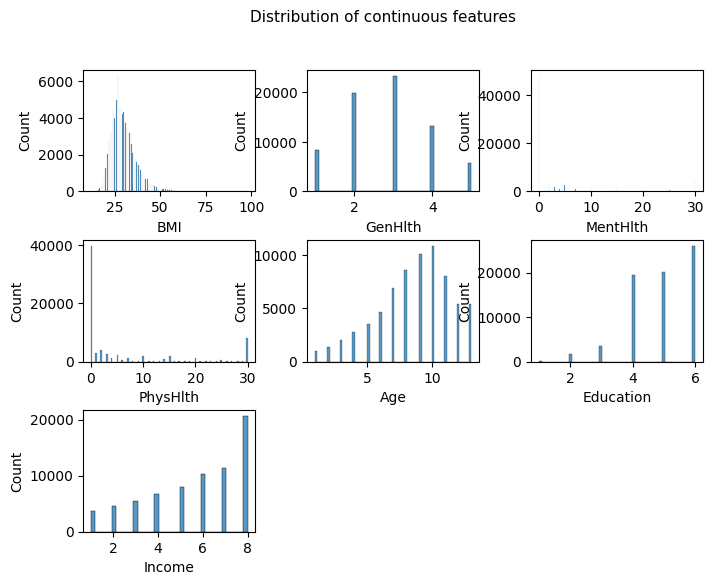

In [9]:
nb_cols=3
fig = plt.figure(figsize=(8,6))
fig.suptitle('Distribution of continuous features', fontsize=11)
gs = fig.add_gridspec(int(np.ceil(len(numerical_columns)/nb_cols)),nb_cols)
gs.update(wspace=0.3, hspace=0.4)
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
    sns.histplot(df[col], ax=ax)

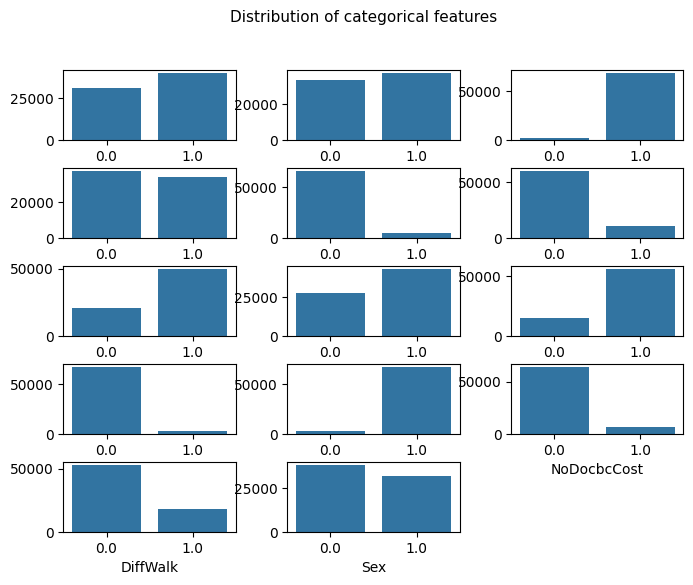

In [10]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Distribution of categorical features', fontsize=11)
gs = fig.add_gridspec(int(np.ceil(len(categorical_columns)/nb_cols)),nb_cols)
gs.update(wspace=0.3, hspace=0.4)
for i, col in enumerate(categorical_columns):
    ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
    plot = sns.countplot(df, x=col)
    plt.ylabel('')

# III/ Preprocessing

In [11]:
#Train/test split
 
X = df.drop(target_column, axis=1)
y = df[target_column]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
n_train=y.size
n_test=y_test.size
 
n,p=X.shape
n_classes= np.unique(y).size
 
#matrice des probas
lb = LabelBinarizer().fit(y)
Y_train = lb.transform(y_train) 
Y_test = lb.transform(y_test) 
 
print("Kolmogorov p_value (train/test même distrib):", np.round(stats.ks_2samp(y_train, y_test)[1],3))
print("Shape of train X,y,Y: ",X_train.shape, y_train.shape, Y_train.shape)
print("Shape of test X,y,Y: ",X_test.shape, y_test.shape, Y_test.shape)
print("Number of classes: ", n_classes)

Kolmogorov p_value (train/test même distrib): 1.0
Shape of train X,y,Y:  (56553, 21) (56553,) (56553, 1)
Shape of test X,y,Y:  (14139, 21) (14139,) (14139, 1)
Number of classes:  2


In [12]:
#On vérifie le ratio 0/1 dans nos échantillons train et test:

Balance_train = np.unique(y_train, return_counts=True)
Prop_train = Balance_train[1]/np.sum(Balance_train[1])
 
Balance_test = np.unique(y_test, return_counts=True)
Prop_test = Balance_test[1]/np.sum(Balance_test[1])
 
print("Balance_train:", Balance_train)
print("Balance_test:", Balance_test)
print("-"*80)
print("Prop_train:", Prop_train)
print("Prop_test:", Prop_test)

Balance_train: (array([0, 1]), array([28256, 28297], dtype=int64))
Balance_test: (array([0, 1]), array([7090, 7049], dtype=int64))
--------------------------------------------------------------------------------
Prop_train: [0.49963751 0.50036249]
Prop_test: [0.50144989 0.49855011]


In [13]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(drop='if_binary'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2)),  
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# IV/ Modelisation

# a) Calibration Hyper-params

In [14]:
#Calibrations des hyper-paramètres
#CV sur 5 fold, optimisation bayésienne
#Le choix de la metric de validation sera le f1-score

def objective(trial):
    params = {
        #Catboost
        "iterations": trial.suggest_int("iterations", 150, 500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.2, log=True),
        "depth": trial.suggest_int("depth", 4, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.5, 1, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 8),
        
#         #RegressionLogisique
#         "C_reg": trial.suggest_float("C_reg", 1, 3, log=True),
        
# #         #RandomForest
#         "n_estimators_rf": trial.suggest_int("n_estimators_rf", 50, 500),
#         "max_depth_rf": trial.suggest_int("max_depth_rf", 3, 15),
#         "max_features_rf": trial.suggest_float("max_features_rf", 0.1, 1.0),
        
#         #Stacking
#         "C_stack": trial.suggest_float("C_stack", 0.5, 3, log=True),
        "threshold": trial.suggest_float("threshold", 0.4, 0.6),
    }

    clf_catboost = CatBoostClassifier(loss_function="Logloss", logging_level='Silent',
                                     iterations=params["iterations"], learning_rate=params["learning_rate"], 
                                     depth=params["depth"], l2_leaf_reg=params["l2_leaf_reg"],
                                     cat_features = categorical_columns)
    
#     clf_reglog = Pipeline(steps=[('preprocessor', preprocessor),
#                                ('classifier', LogisticRegression(penalty = 'l2', C=params['C_reg']))])
    
#     clf_randomforest = RandomForestClassifier(n_estimators=params["n_estimators_rf"],
#                                                max_depth=params["max_depth_rf"],
#                                                max_features=params["max_features_rf"])
    
#     clf_stack = StackingClassifier(estimators=[('catboost', clf_catboost),
#                                               ('random_forest', clf_randomforest),
#                                               ('reg_logistic', clf_reglog)],
#                                   final_estimator=LogisticRegression(penalty = 'l2', C=params['C_stack']), 
#                                   stack_method='predict_proba')
    
    def f1_seuil(y_true, y_pred): return f1_score(y_true, (y_pred >= params["threshold"]).astype("int"), average="macro")
    
    return cross_val_score(clf_catboost, X_train, y_train, cv = 5, 
                           scoring= make_scorer(f1_seuil, needs_threshold=True)).mean()

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
params = study.best_params
print('Best hyperparameters:', params)
print('Best F1-score:', study.best_value)

#params = {'iterations': 317, 'learning_rate': 0.06568159288803004, 'depth': 4, 'l2_leaf_reg': 0.8202954094220084, 'bagging_temperature': 0.9952791479683183, 'C_reg': 1.868424627178635, 'n_estimators_rf': 242, 'max_depth_rf': 3, 'max_features_rf': 0.4838878182180846, }
#Best F1-score: 0.7528195067283383

[I 2024-06-09 11:24:52,326] A new study created in memory with name: no-name-0122faf4-757c-43c2-8d57-9de9c534b36f
[I 2024-06-09 11:25:13,710] Trial 0 finished with value: 0.7443986410606902 and parameters: {'iterations': 332, 'learning_rate': 0.18806886124155406, 'depth': 6, 'l2_leaf_reg': 0.577677137630233, 'bagging_temperature': 2.630983947622771, 'threshold': 0.5567846864686125}. Best is trial 0 with value: 0.7443986410606902.
[I 2024-06-09 11:25:24,524] Trial 1 finished with value: 0.742009072520393 and parameters: {'iterations': 173, 'learning_rate': 0.015884367004090592, 'depth': 6, 'l2_leaf_reg': 0.7083216936593161, 'bagging_temperature': 4.411797127526221, 'threshold': 0.5842638878609738}. Best is trial 0 with value: 0.7443986410606902.
[I 2024-06-09 11:25:49,368] Trial 2 finished with value: 0.7449703220985769 and parameters: {'iterations': 496, 'learning_rate': 0.010626654622458036, 'depth': 5, 'l2_leaf_reg': 0.7176762828457953, 'bagging_temperature': 3.1870949458492257, 'thr

[I 2024-06-09 11:33:41,317] Trial 26 finished with value: 0.7525767695268184 and parameters: {'iterations': 382, 'learning_rate': 0.043603816886196065, 'depth': 4, 'l2_leaf_reg': 0.9179070438858397, 'bagging_temperature': 4.443576194913207, 'threshold': 0.4962379946372011}. Best is trial 21 with value: 0.7534505760801351.
[I 2024-06-09 11:33:56,343] Trial 27 finished with value: 0.7507978042157438 and parameters: {'iterations': 315, 'learning_rate': 0.03782797317396976, 'depth': 4, 'l2_leaf_reg': 0.8534147592783915, 'bagging_temperature': 3.759312971896493, 'threshold': 0.5461360653730797}. Best is trial 21 with value: 0.7534505760801351.
[I 2024-06-09 11:34:09,321] Trial 28 finished with value: 0.7526864382294732 and parameters: {'iterations': 278, 'learning_rate': 0.05050575973215715, 'depth': 4, 'l2_leaf_reg': 0.7803435681026396, 'bagging_temperature': 5.440982207233215, 'threshold': 0.5082167368311226}. Best is trial 21 with value: 0.7534505760801351.
[I 2024-06-09 11:34:26,787] Tr

Best hyperparameters: {'iterations': 374, 'learning_rate': 0.035761059857148635, 'depth': 5, 'l2_leaf_reg': 0.895213185095756, 'bagging_temperature': 4.087424879493904, 'threshold': 0.5037645432080597}
Best F1-score: 0.7534505760801351


## b) Training

In [16]:
clf_catboost = CatBoostClassifier(loss_function="Logloss", logging_level='Silent',
                                  iterations=params["iterations"], learning_rate=params["learning_rate"], 
                                  depth=params["depth"], l2_leaf_reg=params["l2_leaf_reg"],
                                  bagging_temperature = params["bagging_temperature"],
                                  cat_features = categorical_columns)

# clf_reglog = Pipeline(steps=[('preprocessor', preprocessor),
#                              ('classifier', LogisticRegression(penalty = 'l2', C=params['C_reg']))])

# clf_randomforest = RandomForestClassifier(n_estimators=params["n_estimators_rf"],
#                                             max_depth=params["max_depth_rf"],
#                                             max_features=params["max_features_rf"])

# clf_stack = StackingClassifier(estimators=[('catboost', clf_catboost),
#                                            ('random_forest', clf_randomforest),
#                                            ('reg_logistic', clf_reglog)],
#                                final_estimator=LogisticRegression(penalty = 'l2', C=params['C_stack']), 
#                                stack_method='predict_proba')

clf_catboost.fit(X_train, y_train)

# V/ Resultats
## a) Probabilités

In [17]:
#Result model:

#Probabilités
Y_hat_train = clf_catboost.predict_proba(X_train)
Y_hat_test = clf_catboost.predict_proba(X_test)

#Labels
y_hat_train = Y_hat_train[:,1] >= params["threshold"]
y_hat_test = Y_hat_test[:,1] >= params["threshold"]

In [18]:
#Loss
print("Train loss: ", log_loss(Y_train, Y_hat_train))
print("Test loss: ", log_loss(Y_test, Y_hat_test))
 
print("Test loss (random): ", log_loss(Y_test, np.ones(n_test)*Prop_test[1]))

Train loss:  0.49265215058007444
Test loss:  0.49828390442769455
Test loss (random):  0.693142976189859


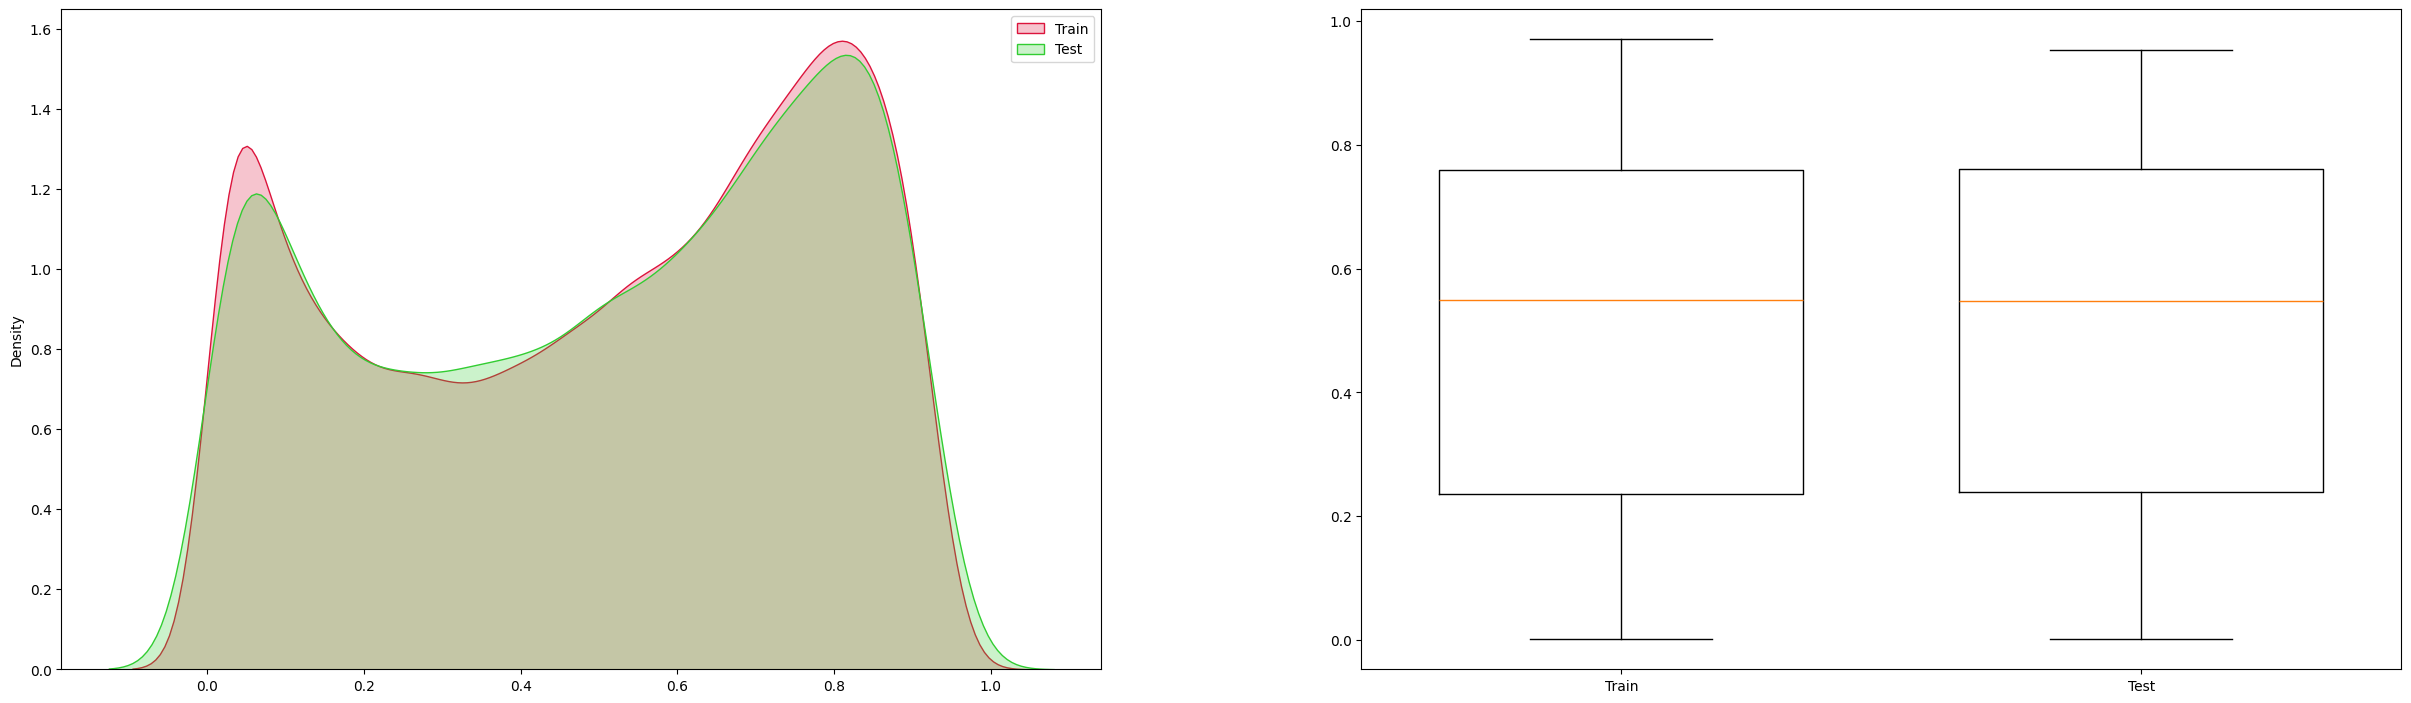

In [19]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
 
sns.kdeplot(data=Y_hat_train[:,1], color='crimson', label="Train", fill=True, ax=ax0)
sns.kdeplot(data=Y_hat_test[:,1], color='limegreen', label="Test", fill=True, ax=ax0)
ax0.legend()
 
ax1.boxplot([Y_hat_train[:,1], Y_hat_test[:,1]], widths=0.7, labels = ["Train", "Test"])
 
plt.subplots_adjust(left=0.05, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

AUC ROC: CatBoost:  0.833 VS Random: 0.5
AUC PR: CatBoost:  0.81 VS Random: 0.499


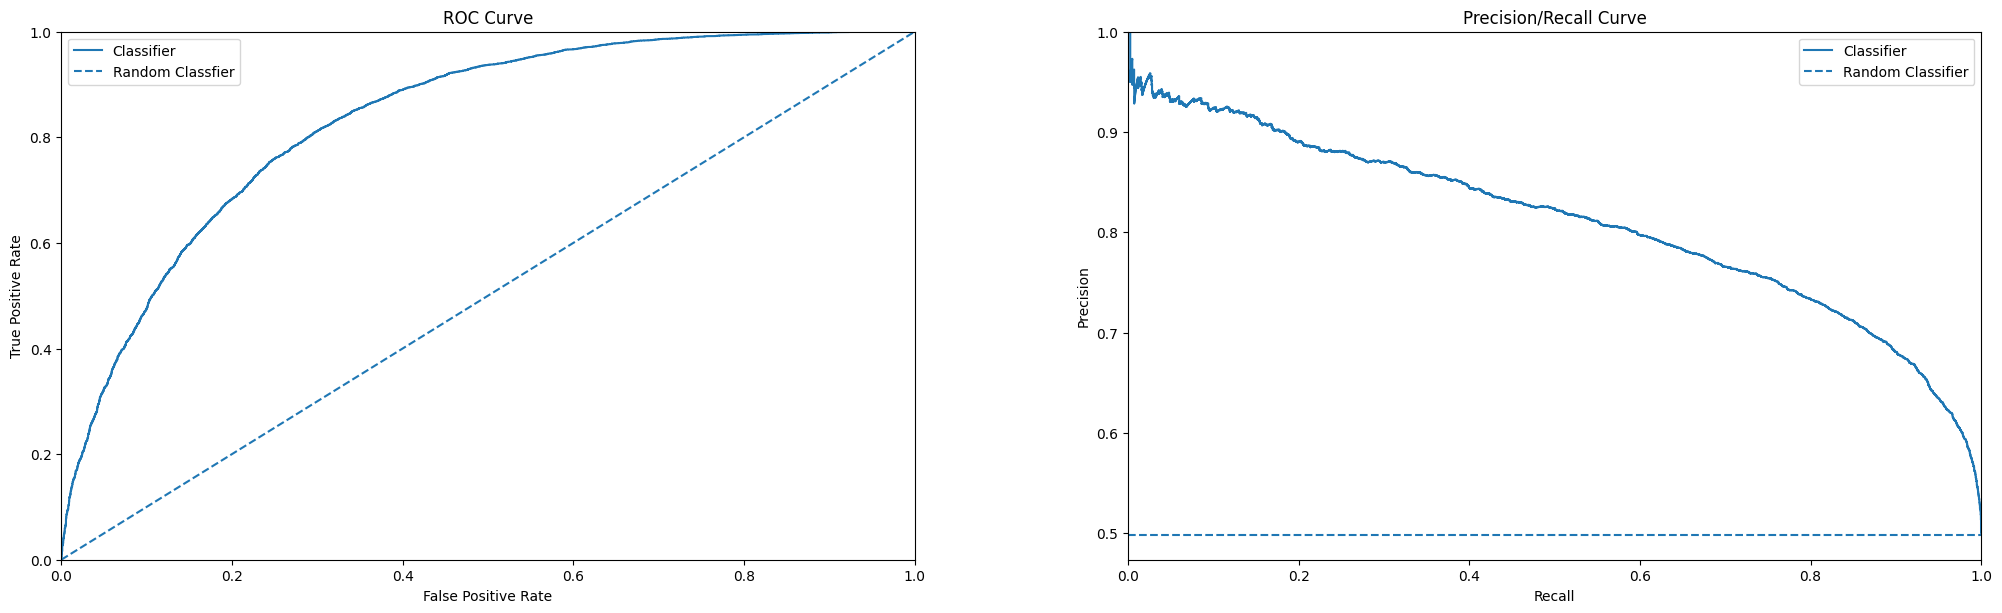

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, Y_hat_test[:,1])
fpr, tpr, thresholds = roc_curve(y_test, Y_hat_test[:,1])
 
fig, (ax1, ax0) = plt.subplots(nrows=1,ncols=2)
 
PrecisionRecallDisplay(precision= precision, recall= recall).plot(ax = ax0, label = "Classifier") 
ax0.axhline(y=Prop_test[1], linestyle="--", label='Random Classifier')
ax0.legend(), ax0.set(xlim=(0, 1), ylim=(Prop_test[1]*0.95, 1), title="Precision/Recall Curve")


RocCurveDisplay(fpr= fpr, tpr= tpr).plot(ax = ax1, label = "Classifier")
ax1.axline((0, 0), slope=1, linestyle = "--", label = 'Random Classfier')
ax1.legend(), ax1.set(xlim=(0, 1), ylim=(0, 1), title="ROC Curve")

plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

print("AUC ROC: CatBoost: ", np.round(auc(fpr, tpr),3), "VS Random:", 0.5)
print("AUC PR: CatBoost: ", np.round(auc(recall, precision),3), "VS Random:", np.round(Prop_test[1],3))

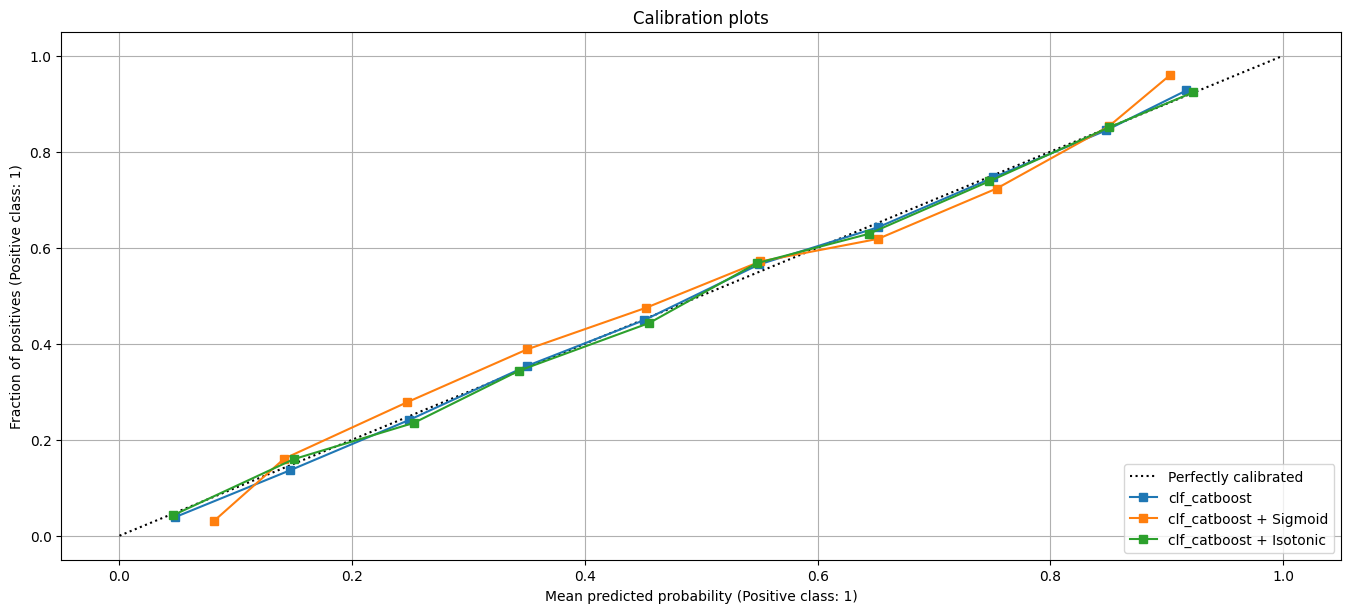

In [22]:
clf_list = [
    (clf_catboost, "clf_catboost"),
    (CalibratedClassifierCV(clf_catboost, cv=5, method="sigmoid"), "clf_catboost + Sigmoid"),
    (CalibratedClassifierCV(clf_catboost, cv=5, method="isotonic"), "clf_catboost + Isotonic"),
]

fig, axis = plt.subplots()

calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(clf, X_test, y_test,
        n_bins=10, name=name, ax=axis, )
    calibration_displays[name] = display

axis.legend(loc='lower right')
axis.grid()
axis.set_title("Calibration plots")

plt.subplots_adjust(left=-1, bottom=-1, right=1, top=0.1, wspace=0.25, hspace=0.5)
plt.show()

## b) Labels

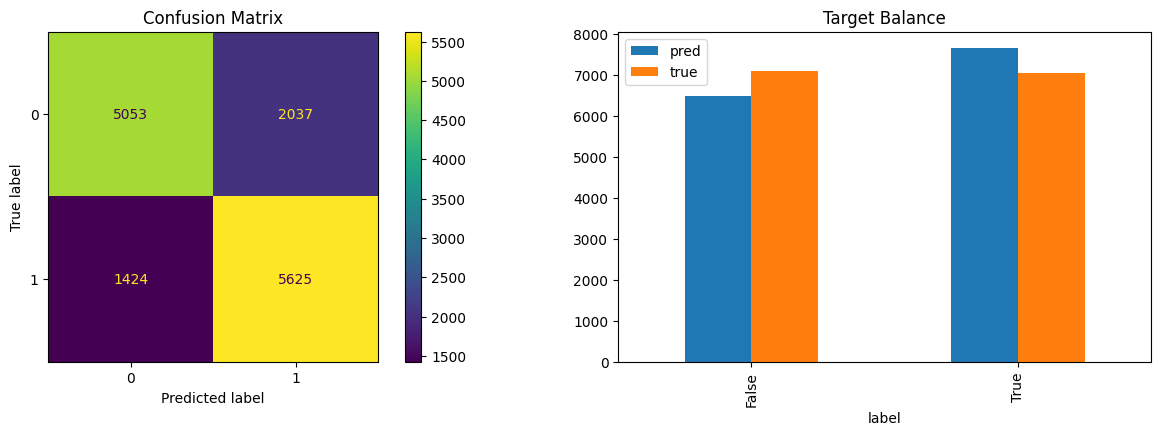

In [23]:
conf_matrix = confusion_matrix(y_test, y_hat_test)

balance = pd.DataFrame(np.unique(y_hat_test, return_counts=True), ["label", "pred"]).T.set_index("label") \
            .merge(pd.DataFrame(Balance_test, ["label", "true"]).T.set_index("label"), on="label")

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(4, 3))  # Adjust the size as needed
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = (["0", "1"]) )
cm_display.plot(ax=ax0)
ax0.set_title('Confusion Matrix')

balance.plot(ax=ax1, kind='bar')
ax1.set_title('Target Balance')

plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

In [24]:
print(classification_report(y_test, y_hat_test, target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      7090
           1       0.73      0.80      0.76      7049

    accuracy                           0.76     14139
   macro avg       0.76      0.76      0.75     14139
weighted avg       0.76      0.76      0.75     14139



# VI/ Explicatibilité

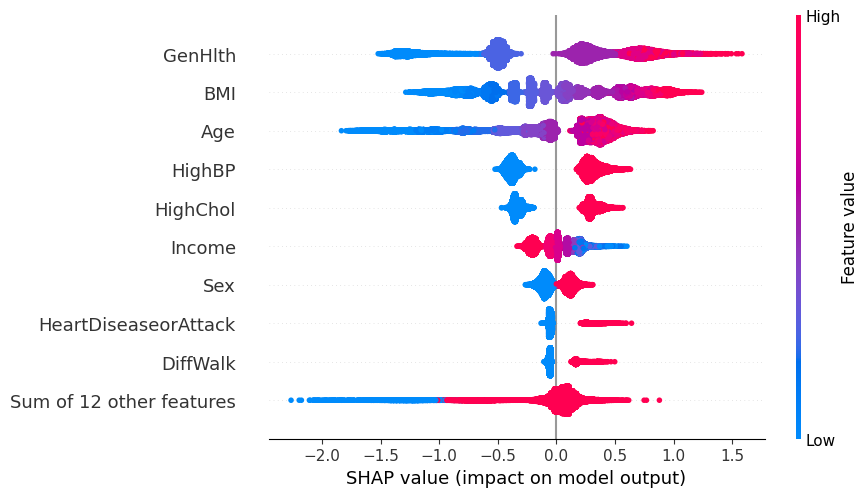

In [25]:
#explainer = sp.TreeExplainer(clf_stack.named_estimators_['catboost'])
explainer = sp.TreeExplainer(clf_catboost)
shap_values_catboost = explainer(X_train)
sp.plots.beeswarm(shap_values_catboost)

In [26]:
# explainer = sp.TreeExplainer(clf_stack.named_estimators_['random_forest'])
# shap_values_rf = explainer(X_train)
# sp.plots.beeswarm(shap_values_rf[:,:,1])

In [27]:
# encoded_columns = clf_stack.named_estimators_['reg_logistic'].named_steps['preprocessor'].transformers_[1][1] \
#                     .named_steps['onehot'].get_feature_names_out(input_features=categorical_columns)

# for feature_name, coef in zip(list(numerical_columns) + list(encoded_columns), clf_stack.named_estimators_['reg_logistic'].named_steps['classifier'].coef_[0]):
#     print(f"{feature_name}: {coef}")

In [28]:
# pd.DataFrame(clf_stack.final_estimator_.coef_, columns = clf_stack.get_feature_names_out())

# VII/ Final training

In [29]:
clf_final = clf_catboost.fit(X, y)

In [30]:
#Result model:

#Probabilités
Y_hat = clf_final.predict_proba(X)

#Loss
print("Train loss: ", log_loss(y, Y_hat)) 
print("Train loss (random): ", log_loss(y, np.ones(n)*Prop_test[1]))

Train loss:  0.4935646765969541
Train loss (random):  0.6931513849418162
